<a href="https://colab.research.google.com/github/SifaMansuri/CE888/blob/main/Assignment1_offensive_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
from collections import Counter
from pprint import pprint
import en_core_web_sm

In [13]:
TRAIN_TEXT = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_text.txt'
VAL_TEXT = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_text.txt'

TRAIN_LABEL = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_labels.txt'
VAL_LABEL = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_labels.txt'


In [14]:
def convert_to_df(data, label):
    tweet = []
    sentiments = []
    for sentence in data.split('\n'):
        tweet.append(sentence)
    for sentiment in label.split('\n'):
        try:
            sentiments.append(int(sentiment))
        except ValueError:
            pass
    df= pd.DataFrame(tweet[:-1], columns=['Review Text'])
    df['label'] = sentiments # this colums contains labels in int format

    df['sentiment'] = df.label.apply(lambda x: 'Not-offensive'if x==0 else 'offensive')

    return df

In [15]:
import requests
train_tweets_txt = requests.get(TRAIN_TEXT).text
train_labels_txt = requests.get(TRAIN_LABEL).text

val_tweets_txt = requests.get(VAL_TEXT).text
val_labels_txt = requests.get(VAL_LABEL).text

train_df = convert_to_df(train_tweets_txt, train_labels_txt)
val_df = convert_to_df(val_tweets_txt, val_labels_txt)



In [16]:
df = train_df

([<matplotlib.patches.Wedge at 0x7f076fb868d0>,
 [Text(-0.5577673051458907, 0.9481010670336213, 'Not-offensive'),
  Text(0.5577672163782593, -0.9481011192555614, 'offensive')],
 [Text(-0.3042367118977585, 0.5171460365637933, '66.9%'),
  Text(0.30423666347905054, -0.5171460650484879, '33.1%')])

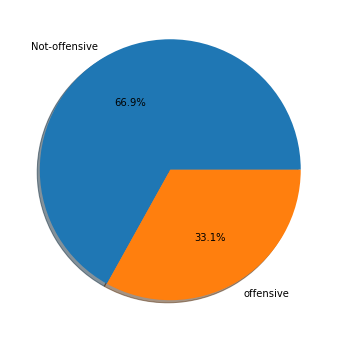

In [17]:
eda = df.groupby('sentiment').count()['Review Text'].reset_index().sort_values(by='Review Text',ascending=False)
labels = list(eda.sentiment)
sizes = list(eda['Review Text'])

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
plt.show()

In [18]:
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText
df['Review Text'] = preprocess(df['Review Text'])

New column for sentiment polarity. Two new columns for lengths of the review and word count.

In [19]:
df['polarity'] = df['Review Text'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['Review Text'].astype(str).apply(len)
df['word_count'] = df['Review Text'].apply(lambda x: len(str(x).split()))

In [20]:
print('5 random reviews with the highest positive sentiment polarity: \n')
cl = df.loc[df.polarity == 1, ['Review Text']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 

@user you are so wonderful Elizabeth...kisses from Italy.... 
@user Beautiful booty!!! 
@user ORourke is just one more ignorant gun control freak........don’t know what they are talking about!!!! 
@user @user #Westminster @user #Tories @user @user @user #Brexiteers #OutOfTheEU @user We think not #AnnaSourpuss 😠 Best for the #UK 🇬🇧 without a doubt is to #Leave with #NoEUDeal ; just get on forging 🌍 trade deals ; say to the #EU #FuckEU 💪 
@user @user What a wonderful caring president we have. God bless him!! #MAGA 


In [21]:
print('5 random reviews with the most neutral sentiment(zero) polarity: \n')
cl = df.loc[df.polarity == 0, ['Review Text']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the most neutral sentiment(zero) polarity: 

@user @user you are running scared!🤡 
#Police? #Banter Training?  Oh my God! Fools and Tools.  #MAGA #MEGA #MBGA #MCGA #Conservatives #Patriots 
@user I still want yo know when you are doing stairway to heaven. 🤣 
@user He is doing life tho😑 
@user Holder should've been removed and jailed years ago. 


### Dist plot of review polarity score

In [22]:
df['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

Vast majority of the polarity are greater than 0, means most of them are positive.

### Distribution of ratings

The ratings are in align with the polarity, that is, most of the ratings are at 4 or 5 range.

### Reviewers age distribution

Most reviewers are in their 30s to 40s.

In [23]:
df['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

### Top unigrams before removing stop words

In [24]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user 29961
the 8134
is 5859
to 5589
you 4920
and 4604
of 3441
are 3236
he 2778
that 2731
it 2433
in 2432
she 2303
for 2250
this 1656
on 1513
they 1496
not 1493
with 1328
have 1321


### Top unigrams after removing stop words

In [25]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user 29961
liberals 1293
gun 1245
control 1106
antifa 1084
like 1005
maga 939
just 902
conservatives 860
people 834
don 781
trump 587
know 563
think 488
right 444
good 421
time 353
want 331
shit 328
need 325


### Top bigrams before removing stop words

In [26]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user user 18111
you are 1455
he is 1415
she is 1336
gun control 1031
user you 620
of the 603
user he 550
in the 503
user she 414
to be 359
is the 355
this is 325
on the 294
to the 293
user the 288
for the 268
user and 264
if you 250
is not 228


In [27]:
df3.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review before removing stop words')

### Top bigrams after removing stop words

In [28]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user user 18173
gun control 1031
user liberals 209
user just 160
user don 158
user antifa 153
user think 107
user yes 105
control laws 102
user good 100
user gun 93
user conservatives 86
user oh 84
user know 76
don know 73
user love 72
user thank 71
user did 70
user maga 66
user really 65


In [29]:
df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')

### Top trigrams before removing stop words

In [30]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user user user 13316
user you are 347
user he is 332
user she is 317
user user you 266
user user he 190
user user she 183
user user the 129
gun control laws 102
user this is 99
user user it 93
he is the 82
user user and 81
user user so 81
you are the 80
for gun control 76
user user that 75
user user this 74
she is the 69
you are not 68


In [31]:
df5.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review before removing stop words')

### Top trigrams after removing stop words

In [32]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user user user 13338
gun control laws 102
user user liberals 99
user gun control 87
user user antifa 81
user user don 78
user user just 71
user user yes 52
user user think 48
user user gun 48
user user conservatives 45
user user oh 44
user user know 39
user user good 36
user user really 34
tcot maga rednationrising 33
user user did 31
user user thank 29
user user love 29
user user people 28


In [33]:
df6.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review after removing stop words')

### Top 20 part-of-speech tagging of review corpus

In [34]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
blob = TextBlob(str(df['Review Text']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 20 Part-of-speech tagging for review corpus')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### Topic Modeling with LSA

In [35]:
reindexed_data = df['Review Text']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [36]:
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [37]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [38]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [39]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [40]:
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  user antifa conservatives
Topic 2:  gun control user
Topic 3:  user liberals like
Topic 4:  liberals user ruin
Topic 5:  maga user trump
Topic 6:  yes fuck user


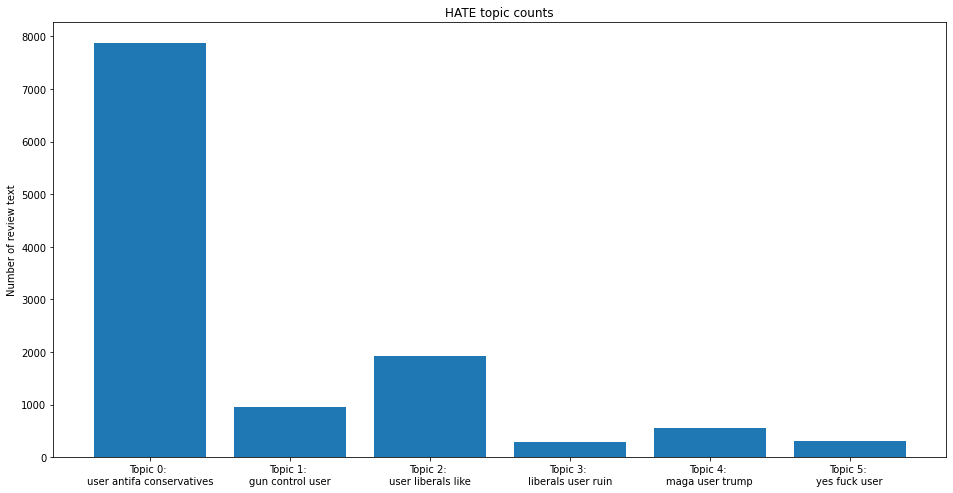

In [41]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('HATE topic counts');
plt.show();

In [42]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 11916 samples in 0.016s...
[t-SNE] Computed neighbors for 11916 samples in 0.978s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11916
[t-SNE] Computed conditional probabilities for sample 2000 / 11916
[t-SNE] Computed conditional probabilities for sample 3000 / 11916
[t-SNE] Computed conditional probabilities for sample 4000 / 11916
[t-SNE] Computed conditional probabilities for sample 5000 / 11916
[t-SNE] Computed conditional probabilities for sample 6000 / 11916
[t-SNE] Computed conditional probabilities for sample 7000 / 11916
[t-SNE] Computed conditional probabilities for sample 8000 / 11916
[t-SNE] Computed conditional probabilities for sample 9000 / 11916
[t-SNE] Computed conditional probabilities for sample 10000 / 11916
[t-SNE] Computed conditional probabilities for sample 11000 / 11916
[t-SNE] Computed conditional probabilities for sample 11916 / 11916
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergenc

In [43]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        reviews_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                reviews_in_that_topic.append(two_dim_vectors[i])    
        
        reviews_in_that_topic = np.vstack(reviews_in_that_topic)
        mean_review_in_that_topic = np.mean(reviews_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_review_in_that_topic)
    return mean_topic_vectors

In [44]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [45]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

GlyphRenderer(id='1037', ...)

Here are the terms that differentiate the review text from a general English corpus.

Here are the terms in review text that are most associated with Tops department: